In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np 
import PIL
import os as os 


# Pretraining  

In [2]:
#Load MNIST for pretraining 
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

In [3]:
#Verify data shape
train_loader.dataset.__getitem__(0)[0].shape

torch.Size([1, 28, 28])

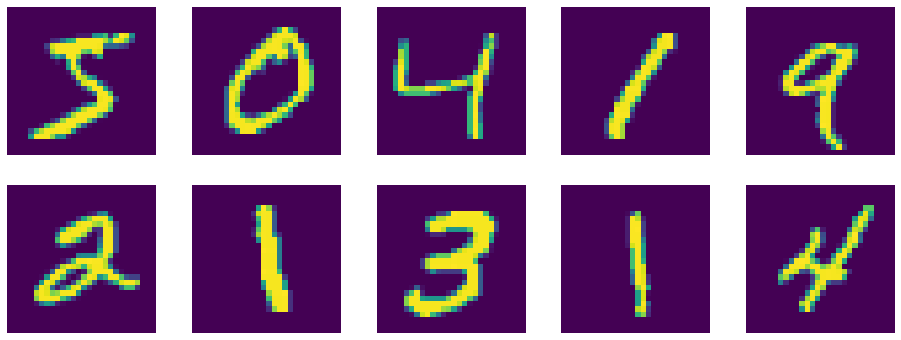

In [4]:
#Plot some examples
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')

In [5]:
#Model Architecture
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(96, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.reshape(-1, 6*4*4 )
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [112]:
#Train and Test Cycles
accuracy_list = []
def train(epoch, model, train_loader, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, test_loader, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [7]:
# Training settings 
n_features = 6 # number of feature maps
model_cnn = CNN(input_size, n_features, output_size)
EPOCHS = 2
device = "cuda:0"
model_cnn.to(device)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

#Pre Train 
for epoch in range(EPOCHS):
    train(epoch, model_cnn, train_loader)
    test(model_cnn, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314753
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.276377
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.180767
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.270362
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.245437
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.229848
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.118939
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.260409
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.090130
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.054614

Test set: Average loss: 0.1123, Accuracy: 9637/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.115612
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.140177
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.110056
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.087413
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.080943
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.115318
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.164307
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.124545
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.026350
T

In [13]:
#Example Image Label and NN Classfication 
image, label = train_loader.dataset.__getitem__(9)
label, model_cnn((image[None, :, :,:]).cuda()).argmax().item()

(4, 4)

# Transfer Learning

In [14]:
#Order files for labeling
files = os.listdir(".\scores")
files = files[:2] + files[8:16] + files[2:8] + files[16:18] + files[24:32] + files[18:24]

In [15]:
tensor_normalize = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
disruptions = transforms.Compose([transforms.RandomAffine(degrees=(10), translate=(.1, .1), scale=(.8, 1))])

In [16]:
#Read in images and store in single 3d-array, create labels
directory = ".\scores"

batch = torch.Tensor(size=(32, 28, 28))

for i, image in enumerate(files):

    PIL_image = PIL.Image.open(os.path.join(directory, image))
    image_data = tensor_normalize(np.array(PIL_image))
    batch[i] = image_data


labels = torch.arange(0, 16).repeat(2)

In [17]:
#Check Dimensions 
batch.shape, labels.shape, batch.mean(), batch.max()

(torch.Size([32, 28, 28]), torch.Size([32]), tensor(1.8104), tensor(2.8215))

In [20]:
#Dataset Declaration 
class ScoresDataset(Dataset):
    def __init__(self, images, labels, transforms=None, reps=1):

        self.perm = torch.randperm(images.shape[0]*reps)
        self.data = images.repeat(reps,1, 1, 1)[self.perm].reshape(images.shape[0]*reps, 1, images.shape[2], images.shape[2])
        self.labels = labels.repeat(reps)[self.perm]
        self.transforms = transforms

        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
            if self.transforms:
                return self.transforms(self.data[idx]), self.labels[idx]

            else:
                return self.data[idx], self.labels[idx]


In [21]:
#Construct Datasets
train_data = torch.utils.data.DataLoader(ScoresDataset(batch[:, None], labels, disruptions, reps=1000), batch_size=10)
test_data = torch.utils.data.DataLoader(ScoresDataset(batch[:, None], labels, disruptions, reps=1000), batch_size=1000)

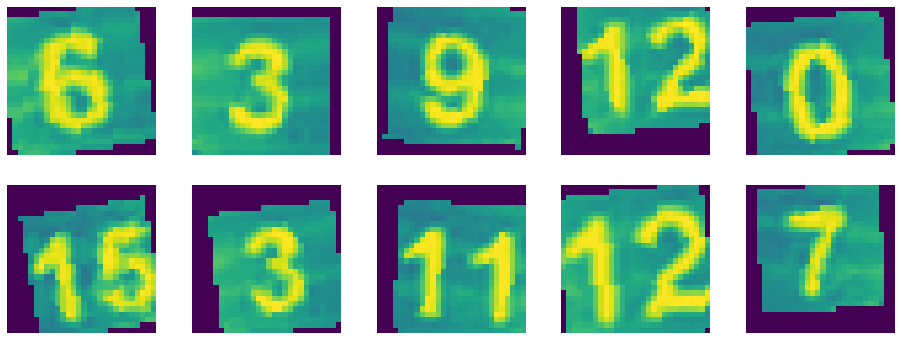

In [22]:
#Plot transformed data 
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_data.dataset.__getitem__(i*7)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')

In [23]:
#Model Surgery to Change Last Layer 
model_cnn.fc2 = nn.Linear(in_features=50, out_features=16, bias=True)
model_cnn.cuda()

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=96, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=16, bias=True)
)

In [102]:
train = train_data.dataset.data.squeeze().reshape(train_data.dataset.data.shape[0], -1)

In [103]:
test = test_data.dataset.data.squeeze().reshape(test_data.dataset.data.shape[0], -1)

In [105]:
model = LogisticRegression().fit(train, train_data.dataset.labels)
res = model.predict(test)
len(np.where(res == np.array(test_data.dataset.labels))[0])/len(np.array(test_data.dataset.labels))

C:\Users\liamc\anaconda3\envs\fencing_viz\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1.0

In [108]:
%%time 
model.predict(test)

Wall time: 192 ms


array([12, 10,  7, ..., 14,  7,  8], dtype=int64)

In [116]:
from joblib import dump, load
dump(model, 'score_classifier.joblib')

['score_classifier.joblib']

In [115]:
%%time 
for data, labels in test_data:
    model_cnn(data.cuda())


Wall time: 9.96 s


In [24]:
EPOCHS=1
for epoch in range(EPOCHS):
    train(epoch, model_cnn, train_data)
    test(model_cnn, test_data)

Train Epoch: 0 [0/32000 (0%)]	Loss: 4.233248
Train Epoch: 0 [1000/32000 (3%)]	Loss: 2.295192
Train Epoch: 0 [2000/32000 (6%)]	Loss: 1.560259
Train Epoch: 0 [3000/32000 (9%)]	Loss: 1.267678
Train Epoch: 0 [4000/32000 (12%)]	Loss: 0.363783
Train Epoch: 0 [5000/32000 (16%)]	Loss: 0.523622
Train Epoch: 0 [6000/32000 (19%)]	Loss: 0.246152
Train Epoch: 0 [7000/32000 (22%)]	Loss: 0.292531
Train Epoch: 0 [8000/32000 (25%)]	Loss: 0.376052
Train Epoch: 0 [9000/32000 (28%)]	Loss: 0.382660
Train Epoch: 0 [10000/32000 (31%)]	Loss: 0.476923
Train Epoch: 0 [11000/32000 (34%)]	Loss: 0.491052
Train Epoch: 0 [12000/32000 (38%)]	Loss: 0.363345
Train Epoch: 0 [13000/32000 (41%)]	Loss: 0.459896
Train Epoch: 0 [14000/32000 (44%)]	Loss: 0.407653
Train Epoch: 0 [15000/32000 (47%)]	Loss: 0.071535
Train Epoch: 0 [16000/32000 (50%)]	Loss: 0.126649
Train Epoch: 0 [17000/32000 (53%)]	Loss: 0.176356
Train Epoch: 0 [18000/32000 (56%)]	Loss: 0.197077
Train Epoch: 0 [19000/32000 (59%)]	Loss: 0.076402
Train Epoch: 0 [2

In [33]:
#Check example 
data, label = train_data.dataset.__getitem__(1)
model_cnn(data[None].cuda()).argmax().item(), label.item()

(11, 11)

In [34]:
#Save model 
path = os.path.join(os.getcwd(), 'trained_score_classifier.pt')
torch.save(model_cnn.state_dict(), path)

# Time Classifier


In [29]:
seconds_path = os.path.join(os.getcwd(), 'outputs', 'seconds')
files = os.listdir(seconds_path)


['seconds_00.jpg',
 'seconds_01.jpg',
 'seconds_02.jpg',
 'seconds_03.jpg',
 'seconds_04.jpg',
 'seconds_05.jpg',
 'seconds_06.jpg',
 'seconds_07.jpg',
 'seconds_08.jpg',
 'seconds_09.jpg',
 'seconds_10.jpg',
 'seconds_11.jpg',
 'seconds_12.jpg',
 'seconds_13.jpg',
 'seconds_14.jpg',
 'seconds_15.jpg',
 'seconds_16.jpg',
 'seconds_17.jpg',
 'seconds_18.jpg',
 'seconds_19.jpg',
 'seconds_20.jpg',
 'seconds_21.jpg',
 'seconds_22.jpg',
 'seconds_23.jpg',
 'seconds_24.jpg',
 'seconds_25.jpg',
 'seconds_26.jpg',
 'seconds_27.jpg',
 'seconds_28.jpg',
 'seconds_29.jpg',
 'seconds_30.jpg',
 'seconds_31.jpg',
 'seconds_32.jpg',
 'seconds_33.jpg',
 'seconds_34.jpg',
 'seconds_35.jpg',
 'seconds_36.jpg',
 'seconds_37.jpg',
 'seconds_38.jpg',
 'seconds_39.jpg',
 'seconds_40.jpg',
 'seconds_41.jpg',
 'seconds_42.jpg',
 'seconds_43.jpg',
 'seconds_44.jpg',
 'seconds_45.jpg',
 'seconds_46.jpg',
 'seconds_47.jpg',
 'seconds_48.jpg',
 'seconds_49.jpg',
 'seconds_50.jpg',
 'seconds_51.jpg',
 'seconds_52

In [34]:
np.array(PIL.Image.open(os.path.join(seconds_path,files[0]))).shape


(28, 37)

In [65]:

#Read in images and store in single 3d-array, create labels


sec_batch = torch.Tensor(size=(60, 28, 37))

for i, image in enumerate(files):

    PIL_image = PIL.Image.open(os.path.join(seconds_path, image))
    image_data = tensor_normalize(np.array(PIL_image))
    sec_batch[i] = image_data

In [66]:
sec_labels = torch.arange(0, 60)

In [213]:
#Dataset Declaration 
class SecondsDataset(Dataset):
    def __init__(self, images, labels, transforms=None, reps=1):

        self.perm = torch.randperm(images.shape[0]*reps)
        self.data = images.repeat(reps,1, 1, 1)[self.perm].reshape(images.shape[0]*reps, 1, images.shape[2], images.shape[3])
        self.labels = labels.repeat(reps)[self.perm]
        self.transforms = transforms

        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
            if self.transforms:
                return self.transforms(self.data[idx]), self.labels[idx]

            else:
                return self.data[idx], self.labels[idx]
#Dataset Declaration 
class MinutesDataset(Dataset):
    def __init__(self, images, labels, transforms=None, reps=1):

        self.perm = torch.randperm(images.shape[0]*reps)
        print(images.repeat(reps, 1, 1).shape)
        self.data = images.repeat(reps, -1)[self.perm]#.reshape(images.shape[0]*reps, 1, images.shape[2], images.shape[3])
        self.labels = labels.repeat(reps)[self.perm]
        self.transforms = transforms

        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
            if self.transforms:
                return self.transforms(self.data[idx]), self.labels[idx]

            else:
                return self.data[idx], self.labels[idx]

In [208]:
seconds_data = SecondsDataset(sec_batch[:, None], sec_labels, reps=100)

In [209]:
sec_batch[:, None].shape

torch.Size([60, 1, 28, 37])

In [210]:
from sklearn.linear_model import LogisticRegression

In [211]:
X = seconds_data.data.squeeze().reshape(seconds_data.data.shape[0],-1)

In [194]:
sec_model = LogisticRegression().fit(X[:-100], seconds_data.labels[:-100])

KeyboardInterrupt: 

In [134]:
np.where(np.array(seconds_data.labels[-100:]) == res)[0].shape

(100,)

In [135]:
dump(sec_model, 'seconds_classifier.joblib')

['seconds_classifier.joblib']

In [136]:
min_path = os.path.join(os.getcwd(), 'outputs', 'minutes')
files = os.listdir(min_path)

In [138]:
np.array(PIL.Image.open(os.path.join(min_path, files[0]))).shape

(28, 22)

In [255]:
min_batch = np.ndarray((4, 28, 22))

for i, file in enumerate(files):
    image_data = np.array(PIL.Image.open(os.path.join(min_path, file)))
    image_data = tensor_normalize(image_data)
    min_batch[i] = image_data

min_batch.shape
labels = torch.arange(0, 4)

In [256]:
min_X = np.tile(min_batch, (100, 1, 1))
min_labels = np.tile(labels, 100)
perm_ind = np.random.permutation(400)
min_X = min_X[perm_ind]
min_labels = min_labels[perm_ind]


In [257]:
train_data = min_X.reshape(400, 28*22)

In [258]:
min_model = LogisticRegression().fit(train_data, min_labels)


C:\Users\liamc\anaconda3\envs\fencing_viz\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [259]:
min_model.predict(train_data)

array([2, 3, 0, 3, 1, 0, 2, 3, 1, 3, 2, 3, 0, 1, 2, 2, 2, 1, 0, 1, 3, 3,
       1, 2, 3, 3, 2, 0, 3, 0, 2, 3, 0, 0, 3, 2, 2, 1, 0, 3, 3, 0, 0, 3,
       0, 1, 3, 3, 2, 3, 2, 1, 2, 2, 2, 0, 3, 0, 0, 2, 1, 1, 2, 0, 1, 2,
       2, 2, 2, 0, 1, 2, 1, 3, 2, 0, 0, 2, 0, 2, 1, 0, 1, 1, 1, 1, 0, 3,
       0, 1, 3, 0, 2, 2, 3, 3, 0, 1, 2, 3, 1, 2, 3, 1, 1, 0, 2, 2, 2, 1,
       3, 3, 1, 1, 0, 0, 2, 3, 3, 2, 3, 1, 2, 0, 3, 1, 0, 3, 2, 1, 0, 1,
       3, 3, 1, 0, 2, 3, 3, 0, 0, 0, 0, 2, 0, 1, 2, 0, 1, 1, 1, 2, 0, 2,
       3, 0, 0, 1, 0, 0, 1, 2, 0, 0, 3, 2, 2, 3, 1, 1, 1, 1, 2, 3, 1, 1,
       3, 0, 3, 2, 0, 3, 2, 1, 1, 2, 2, 3, 1, 1, 2, 0, 1, 1, 2, 3, 3, 2,
       2, 1, 0, 3, 0, 2, 1, 0, 3, 2, 0, 1, 0, 3, 2, 3, 0, 1, 0, 1, 1, 0,
       0, 1, 2, 2, 0, 3, 3, 2, 2, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 1, 2, 3,
       2, 2, 3, 0, 0, 3, 3, 1, 1, 2, 1, 2, 1, 0, 2, 0, 1, 3, 0, 0, 0, 2,
       2, 2, 1, 3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 1, 0, 3, 0, 0, 1, 1, 1, 1,
       3, 0, 1, 3, 1, 3, 3, 0, 2, 0, 0, 1, 3, 3, 2,

In [260]:
min_labels

array([2, 3, 0, 3, 1, 0, 2, 3, 1, 3, 2, 3, 0, 1, 2, 2, 2, 1, 0, 1, 3, 3,
       1, 2, 3, 3, 2, 0, 3, 0, 2, 3, 0, 0, 3, 2, 2, 1, 0, 3, 3, 0, 0, 3,
       0, 1, 3, 3, 2, 3, 2, 1, 2, 2, 2, 0, 3, 0, 0, 2, 1, 1, 2, 0, 1, 2,
       2, 2, 2, 0, 1, 2, 1, 3, 2, 0, 0, 2, 0, 2, 1, 0, 1, 1, 1, 1, 0, 3,
       0, 1, 3, 0, 2, 2, 3, 3, 0, 1, 2, 3, 1, 2, 3, 1, 1, 0, 2, 2, 2, 1,
       3, 3, 1, 1, 0, 0, 2, 3, 3, 2, 3, 1, 2, 0, 3, 1, 0, 3, 2, 1, 0, 1,
       3, 3, 1, 0, 2, 3, 3, 0, 0, 0, 0, 2, 0, 1, 2, 0, 1, 1, 1, 2, 0, 2,
       3, 0, 0, 1, 0, 0, 1, 2, 0, 0, 3, 2, 2, 3, 1, 1, 1, 1, 2, 3, 1, 1,
       3, 0, 3, 2, 0, 3, 2, 1, 1, 2, 2, 3, 1, 1, 2, 0, 1, 1, 2, 3, 3, 2,
       2, 1, 0, 3, 0, 2, 1, 0, 3, 2, 0, 1, 0, 3, 2, 3, 0, 1, 0, 1, 1, 0,
       0, 1, 2, 2, 0, 3, 3, 2, 2, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 1, 2, 3,
       2, 2, 3, 0, 0, 3, 3, 1, 1, 2, 1, 2, 1, 0, 2, 0, 1, 3, 0, 0, 0, 2,
       2, 2, 1, 3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 1, 0, 3, 0, 0, 1, 1, 1, 1,
       3, 0, 1, 3, 1, 3, 3, 0, 2, 0, 0, 1, 3, 3, 2,

In [261]:
path_problem = os.path.join(os.getcwd(), "time.jpg")

In [266]:
image_base = PIL.Image.open(path_problem)
image_base.show()
problem_image = np.array(tensor_normalize(np.array(image_base))).reshape(1, -1)
min_model.predict(problem_image)

array([0], dtype=int64)

In [248]:
min_model.predict(train_data[8].reshape(1, -1))

array([2], dtype=int64)

In [249]:
min_labels[8]

2

In [251]:
dump(min_model, 'min_classifier.joblib')

['min_classifier.joblib']